In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [196]:
from typing import List, Union, Dict

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.cloud import bigquery
from scipy.stats import chi2_contingency

from queries import FETCH_DATASET_FLAT
from configurations import CATEGORICAL_FEATRUES, TARGET
client = bigquery.Client()

engagements = client.query(FETCH_DATASET_FLAT).to_dataframe() 

In [225]:
print('Number of recorded engagemant:', engagements.shape[0])
print('Number of features:', engagements.shape[1])

Number of recorded engagemant: 25842
Number of features: 25


In [226]:
def phenomena_rate(df: pd.DataFrame, features: List[str]):
    """
    """
    for feature in features:
        rates = df[feature].value_counts(normalize=True).to_frame()
        absoluts = df[feature].value_counts().to_frame()
        
        plt.figure(figsize=(15, 10))
        plt.title(f'Distribution {feature}')
        plt.grid()
        plt.bar(rates.index, rates[feature]),
        
        for index, rate, absolute in zip(rates.index, rates[feature], absoluts[feature]):
            plt.annotate(f'{round(rate*100, 2)}%\n({absolute})', xy=(index, rate*1.01))
        plt.show()

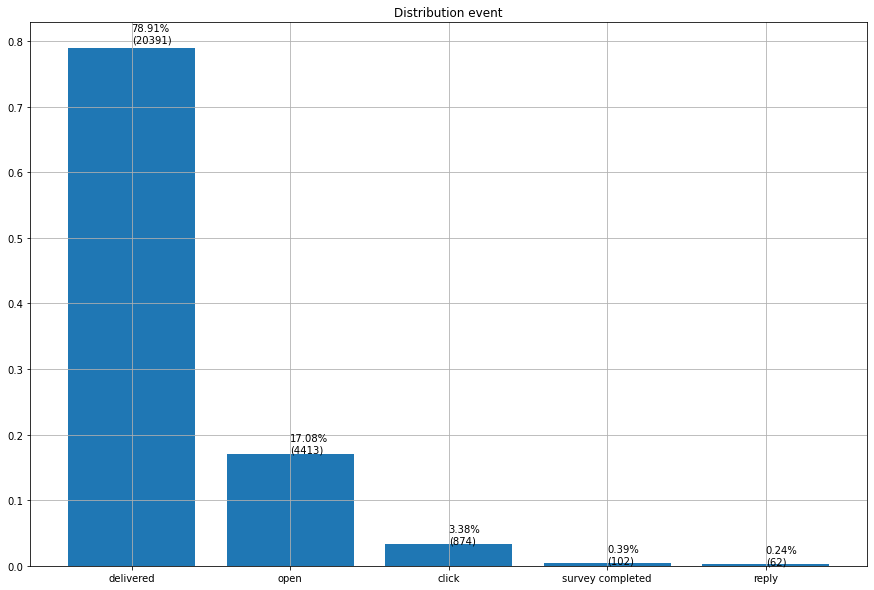

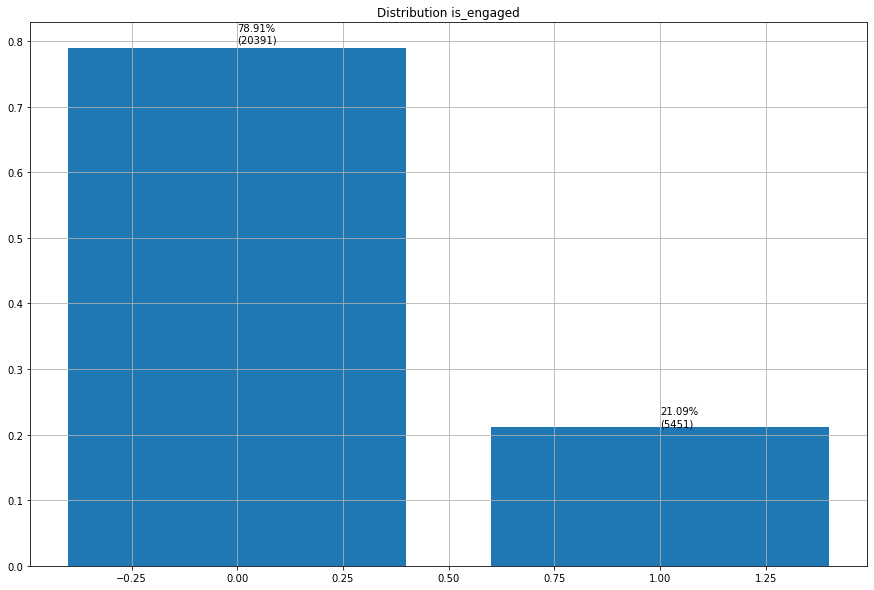

In [227]:
phenomena_rate(engagements, features=['event', TARGET])

In [228]:
def chi_square_indeipendence_test(df: pd.DataFrame, features: List[str], y: str, 
                                  dependency_threshold: float = 0.05) -> pd.DataFrame:
    """
    H0 - The feature is independece with y
    H1 - The feature and yare depend on each other
    p-value - the lowest the more dependency between the feature and y
    """
    dependncy: List[Dict[str, Union[str, float, int]]] = list()
    
    for feature in features:
        cross = pd.crosstab(df[feature], df[y])
        stat, pvalue, dof, expected = chi2_contingency(cross)
        dependncy.append(
            {
                'feature': feature,
                'pvalue': pvalue,
                'degree_of_freedom': dof,
                'is_depended': 1 if pvalue <= dependency_threshold else 0
            }
        )
    
    dependncy_df = pd.DataFrame(dependncy) 
    
    return dependncy_df.sort_values(by='pvalue')

dependncy = chi_square_indeipendence_test(engagements, CATEGORICAL_FEATRUES, TARGET)
dependncy

,feature,pvalue,degree_of_freedom,is_depended
1,part_of_day,0.000000e+00,5,1
9,linkedin_industry,2.241230e-113,129,1
0,campaign_id,7.641091e-70,4,1
6,state,9.541476e-68,69,1
8,company_size,4.304956e-39,6,1
5,country,1.585447e-27,2,1
4,seniority,8.036994e-24,25,1
7,managment_level,1.131619e-08,4,1
2,part_of_week,3.475864e-04,2,1
3,part_of_month,1.516368e-02,2,1


In [232]:
def lift_in_dependency_by_category(df: pd.DataFrame, features: List[str], 
                                   y: str, plot: bool = True) -> Dict[str, pd.DataFrame]:
    """
    Lift refers to a probability to be belong to the positive class divide
    by 
    """
    lifts: Dict[str, pd.DataFrame] = dict()
    
    for feature in features:
        cross = pd.crosstab(df[feature], df[y])
        cross_norm = cross.apply(
            lambda row: row.transform(lambda item: item/row.sum()), 
            axis=1
        )
        
        rates_positive_class = cross_norm[1]
        cross_norm['lift'] = rates_positive_class.apply(
            lambda rate: rate/rates_positive_class.mean()
        )
        cross_norm = cross_norm.sort_values(by='lift', ascending=False).reset_index()
        
        lifts[feature] = cross_norm
        
        if plot:
            size = df[feature].value_counts().to_dict()
            categories = cross_norm[feature][:10]
            categories_lifts = cross_norm['lift'][:10]
            plt.figure(figsize=(14,8))
            plt.grid()
            plt.title(f'Category lift for - {feature} (# categories {cross_norm.shape[0]})')
            plt.bar(categories, categories_lifts)
            plt.xticks(rotation=30)
            
            for category, lift in zip(categories, categories_lifts):
                plt.annotate(f'{round(lift, 2)}\n({size[category]})', xy=(category, lift*1.01))
            
            plt.show()
            
    return lifts

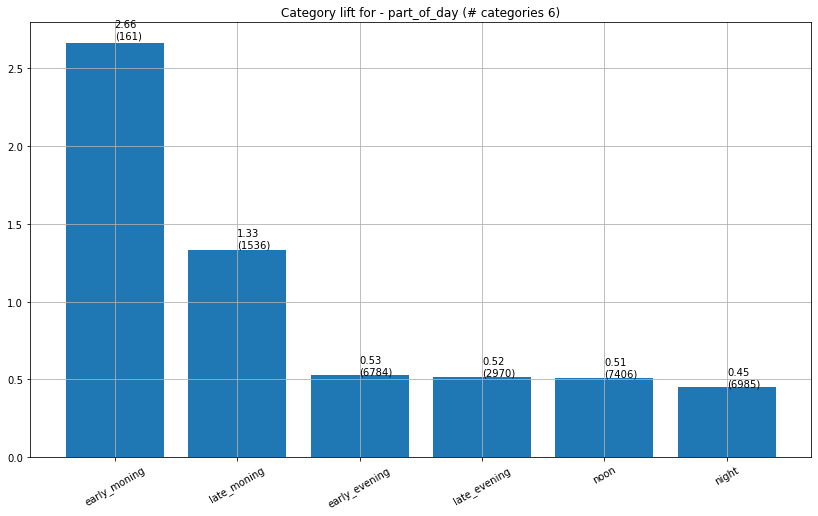

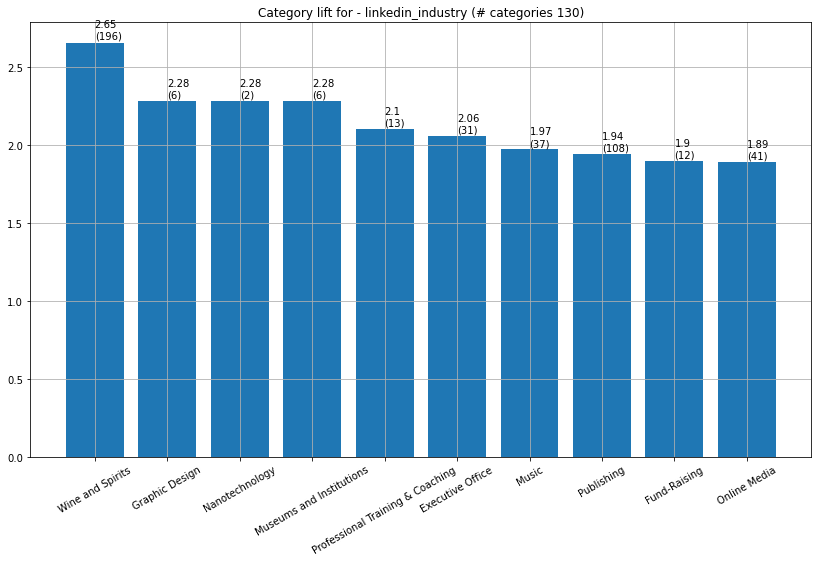

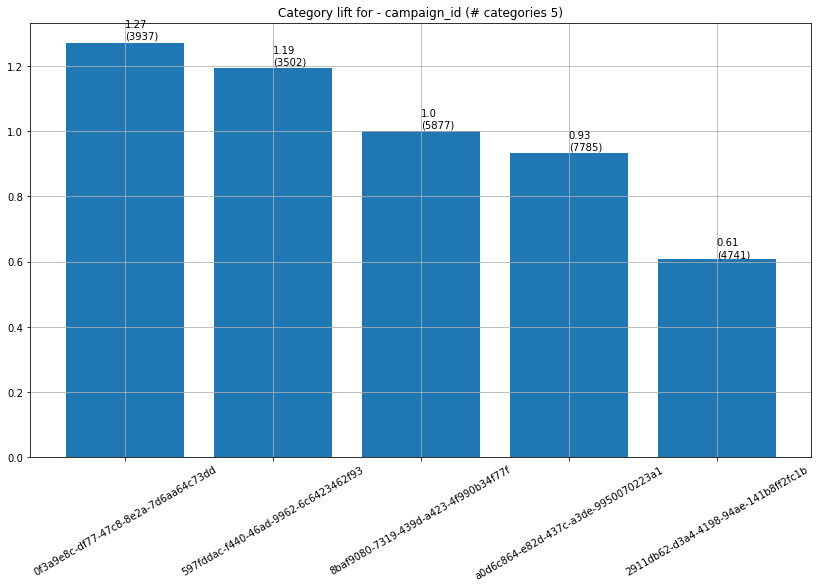

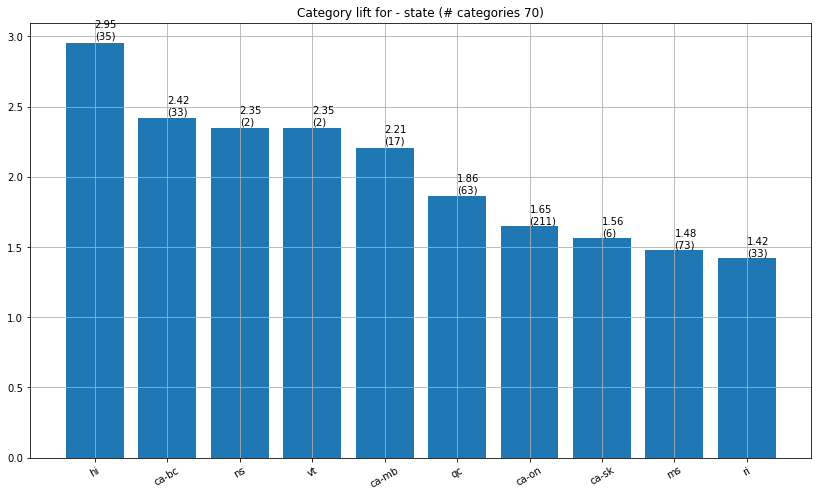

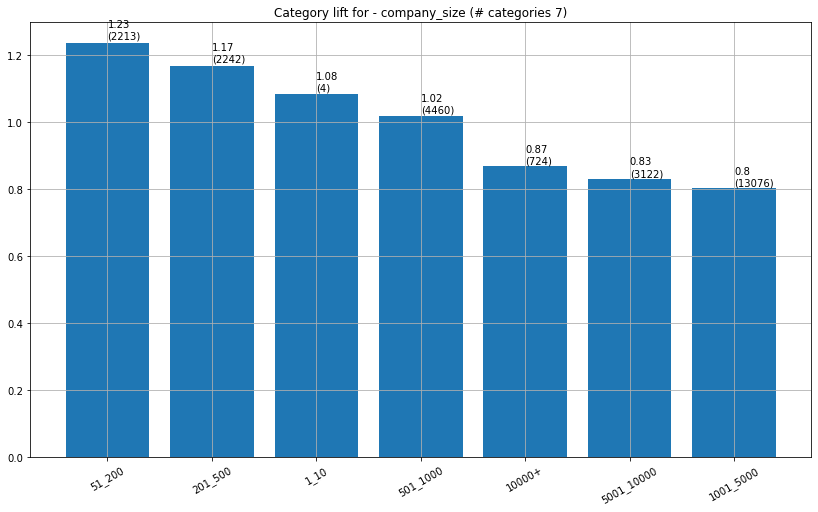

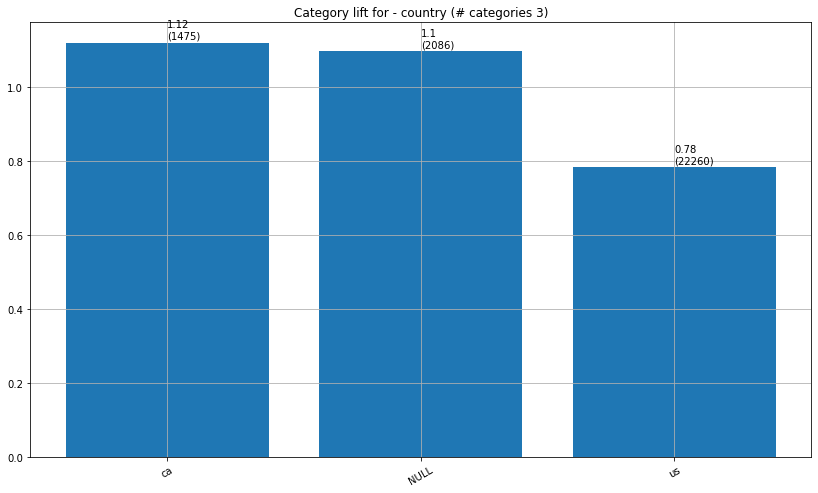

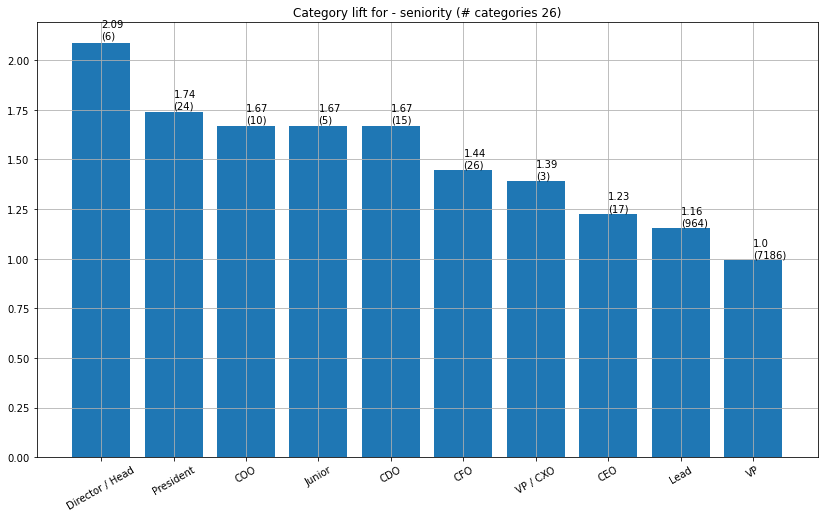

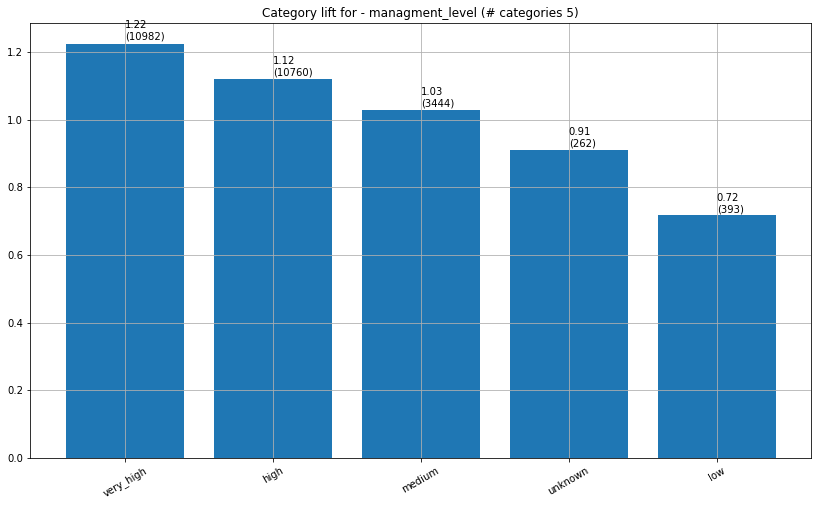

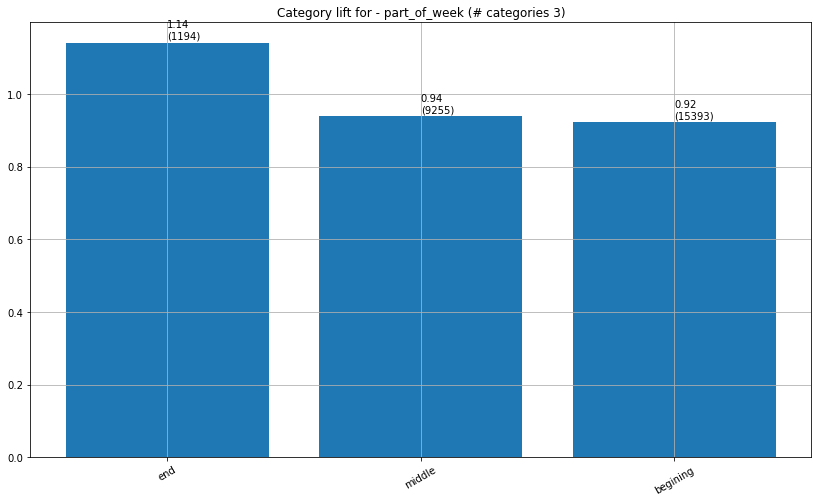

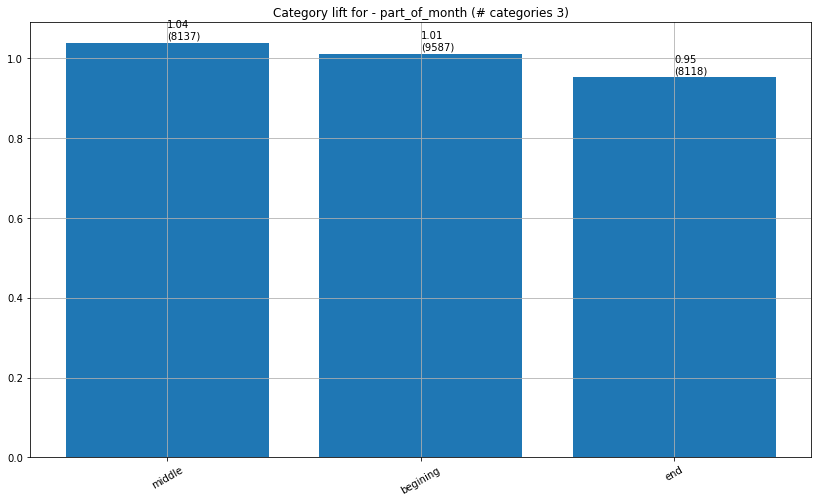

In [233]:
top_features = dependncy.feature.tolist()[:10]
lifts = lift_in_dependency_by_category(engagements, top_features, TARGET)

In [200]:
def plot_relationship_with_numeric(df: pd.DataFrame, features: List[str], y: str):
    """
    """
    for feature in features:
        fig, axs = plt.subplots(ncols=2, figsize=(18,10))
    
        # 1st plot distribution breaks to TARGET classes
        sns.kdeplot(x=feature, data=engagements, hue=TARGET, common_norm=False, ax=axs[0])
        axs[0].set_title(f'Distribution {feature}')
        
        # 2nd plot distribution breaks to TARGET classes
        sns.histplot(
            x=feature, data=engagements, hue=TARGET, stat="density", element="step",
            fill=False, cumulative=True, common_norm=False, ax=axs[1]
        )
        axs[1].set_title(f'Cumulative distribution {feature}')
        
        plt.show()

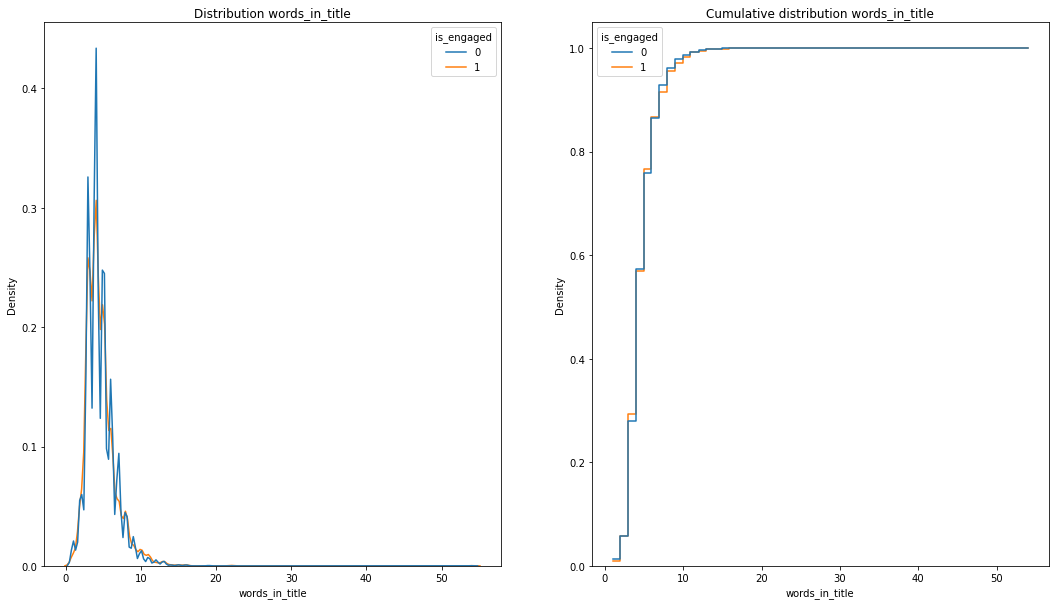

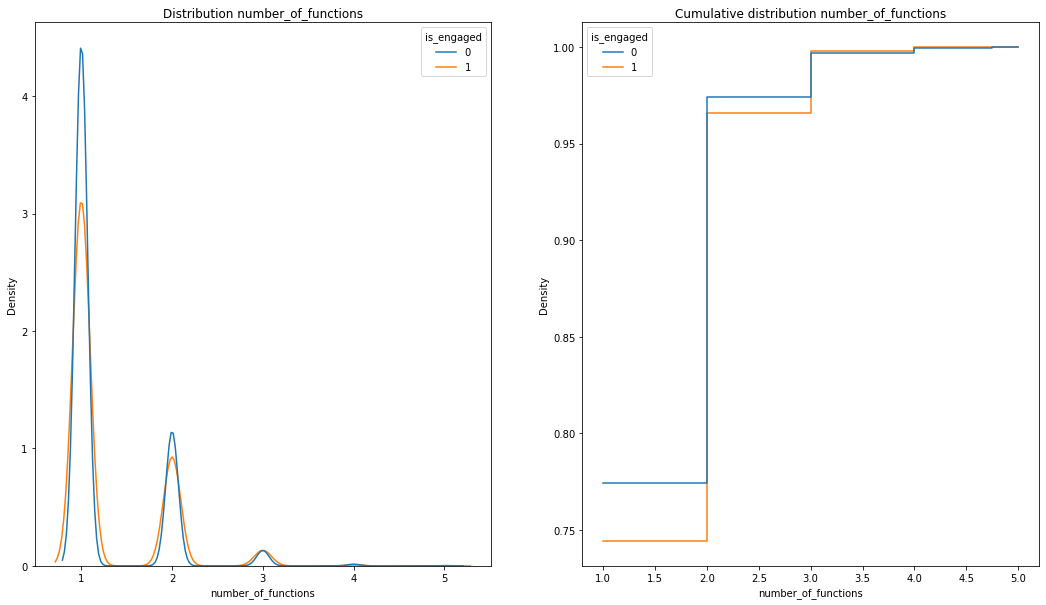

In [201]:
plot_relationship_with_numeric(engagements, ['words_in_title', 'number_of_functions'], TARGET)